# Importando módulos 

In [146]:
import obspy
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
import glidertools as gt
import datetime

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Lista de Funções 

In [147]:
def dm(x):
    south = False
    
    if x<0:
        south = True
        x = abs(x)
        
    degrees = int(x) // 100
    minutes = x - 100*degrees
    
    x = degrees + minutes/60
    if south:
        x = -x
    return x

In [148]:
def check_datetime_in_period(datetime_lst,dataf):
    '''
    Function to check if the dates in data set are inside the chosen time period
    
    '''
    array_to_plot_by_xlim = []
    for x,c in enumerate(datetime_lst):
        lista_temp = []
        for t,y in enumerate(dataf['time'].values):
            if y == c.date():
                lista_temp.append(np.array(dataf[dataf['time'] == y]['NUMBER_HOUR'].tolist()[0]))
        array_to_plot_by_xlim.append(lista_temp)
   
    data_x_axis = []
    for x,c in enumerate(array_to_plot_by_xlim):
        if c != []:
            data_x_axis.append(c[0])
        else:
            data_x_axis.append(np.zeros_like(np.arange(24)))

    data_x_axis = np.array(data_x_axis).T

    return data_x_axis
#----------------------------

In [149]:
FOLDER_OUTPUT = '/home/dIOGOLOC/dados_posdoc/gliders_project/OUTPUT/'

# Calculating datetime between INITIAL_DATE and  FINAL_DATE


In [150]:
# ==========================================================
# Calculating datetime between INITIAL_DATE and  FINAL_DATE
# ==========================================================

datatime_initial = datetime.strptime('2015-01-01', "%Y-%m-%d").date() 

datatime_final = datetime.strptime('2021-12-31', "%Y-%m-%d").date() 

datetime_lista = np.arange(datatime_initial, datatime_final, timedelta(days=1)).astype(datetime)

datetime_lista_years = sorted(list(set([i.strftime("%Y") for i in datetime_lista])))

xlim_initial = mdates.date2num(datatime_initial)
xlim_final = mdates.date2num(datatime_final)

# Extraindo informações dos arquivos ".csv" e criando um dataframe em PANDAS

In [151]:
os.chdir('/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/')

In [152]:
filenames = sorted(glob.glob('*.csv'))[0]

In [153]:
dataframe_csv = pd.read_csv(filenames,parse_dates=['time'])

In [154]:
dataframe_csv.sort_values(by='time')

,time,filename,latitude,longitude,depth
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


In [155]:
dataframe_csv['year'] = dataframe_csv['time'].dt.strftime("%Y")
dataframe_csv['month'] = dataframe_csv['time'].dt.strftime("%m")
dataframe_csv['n_month'] = dataframe_csv['time'].dt.strftime("%b")

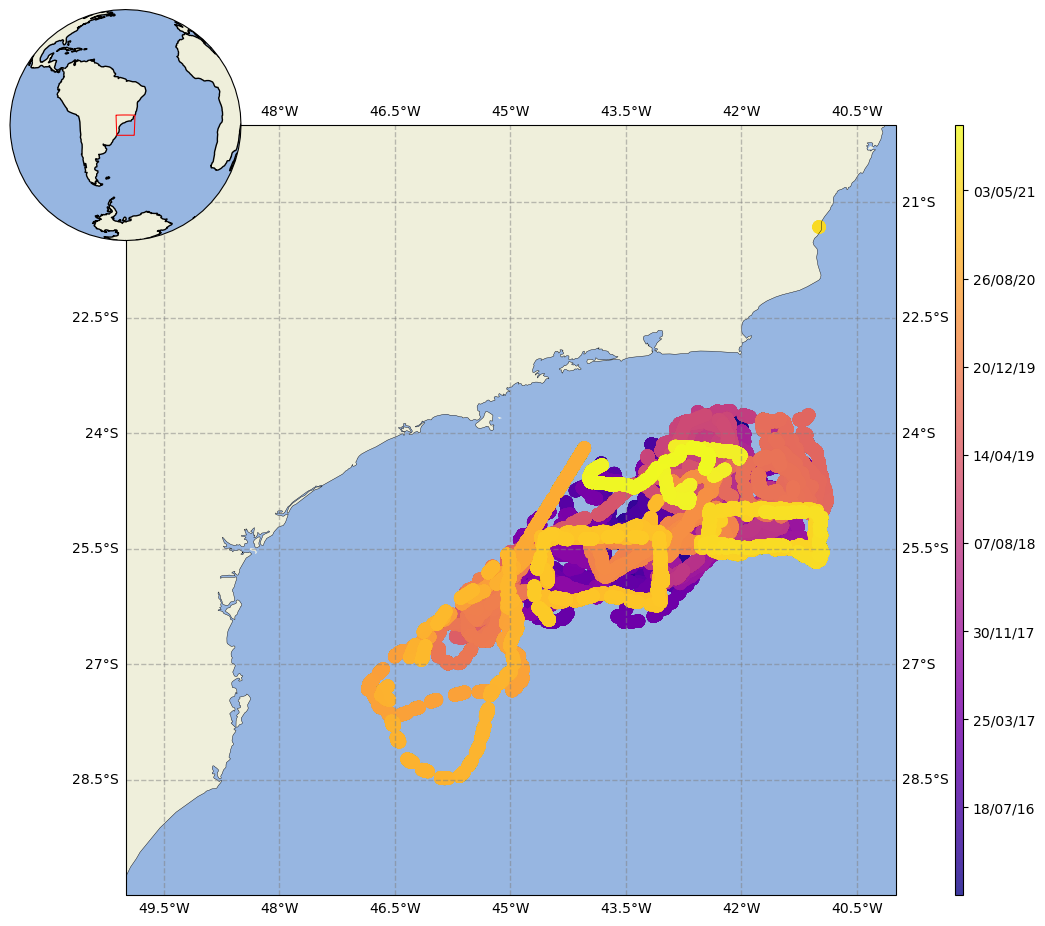

In [81]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_csv['longitude'],dataframe_csv['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax2.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)


# Gráfico Geral

In [156]:
datetime_lista

array([datetime.datetime(2015, 1, 1, 0, 0),
       datetime.datetime(2015, 1, 2, 0, 0),
       datetime.datetime(2015, 1, 3, 0, 0), ...,
       datetime.datetime(2021, 12, 28, 0, 0),
       datetime.datetime(2021, 12, 29, 0, 0),
       datetime.datetime(2021, 12, 30, 0, 0)], dtype=object)

In [161]:
# Get unique values from 'col1'
filtered_dataframe_csv = dataframe_csv.drop_duplicates(subset='filename')


In [160]:
unique_values_filename

array(['pa0001au_001_151112_134841_rms_spl3.mat',
       'pa0001au_002_151112_135041_rms_spl3.mat',
       'pa0001au_003_151112_135241_rms_spl3.mat', ...,
       'pa0296au_010_211104_063338_rms_spl3.mat',
       'pa0296au_011_211104_064338_rms_spl3.mat',
       'pa0296au_012_211104_065338_rms_spl3.mat'], dtype=object)

In [163]:
filtered_dataframe_csv.head(10)

,time,filename,latitude,longitude,depth,year,month,n_month
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286,2015,11,Nov
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000,2015,11,Nov
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000,2015,11,Nov
6,2015-11-12 13:54:41.000004,pa0001au_004_151112_135441_rms_spl3.mat,-23.823920,-42.495506,48.910000,2015,11,Nov
8,2015-11-12 14:36:17.999998,pa0002au_001_151112_143618_rms_spl3.mat,-23.817575,-42.495060,1.467143,2015,11,Nov
10,2015-11-12 14:38:18.000001,pa0002au_002_151112_143818_rms_spl3.mat,-23.817305,-42.494865,17.850000,2015,11,Nov
12,2015-11-12 14:40:18.000004,pa0002au_003_151112_144018_rms_spl3.mat,-23.817032,-42.494670,35.330000,2015,11,Nov
14,2015-11-12 14:42:17.999997,pa0002au_004_151112_144218_rms_spl3.mat,-23.816761,-42.494473,51.190000,2015,11,Nov
16,2015-11-12 14:44:18.000000,pa0002au_005_151112_144418_rms_spl3.mat,-23.816490,-42.494274,67.496000,2015,11,Nov
18,2015-11-12 14:46:18.000003,pa0002au_006_151112_144618_rms_spl3.mat,-23.816217,-42.494080,83.822000,2015,11,Nov


In [164]:
month_date_lst = sorted(list(set(filtered_dataframe_csv['month'].values)))

# creating the array to plot
dataframe_lista = []
for h in tqdm(np.arange(1,13),total=len(np.arange(1,13)), desc='Creating the dataframe:'):
    try:
        df_month = filtered_dataframe_csv[filtered_dataframe_csv['month'] == str(h).zfill(2)]
            
        MONTH_LST = df_month['n_month'].values
        df_temp = [str(h).zfill(2),list(set(MONTH_LST))[0]]
        df_temp_index = ['number_month','n_month']
        for i in datetime_lista_years:
            if df_month['year'].str.contains(i).any():

                df_year = df_month[df_month['year'] == i]
                NUMBER_MINUTES_LST = df_year['year'].value_counts().values

                df_temp.append(NUMBER_MINUTES_LST[0])
                df_temp_index.append(i)
            else:
                df_temp.append(0)
                df_temp_index.append(i) 

        dataframe_lista.append(pd.DataFrame(df_temp, index=df_temp_index).T)
    except:
        pass

df_to_plot = pd.concat(dataframe_lista, ignore_index=True)

name_months = df_to_plot['n_month'].values
data_x_axis = df_to_plot[datetime_lista_years].values.astype(float).T
#-------------------------

Creating the dataframe:: 100%|██████████████████| 12/12 [00:00<00:00, 24.89it/s]


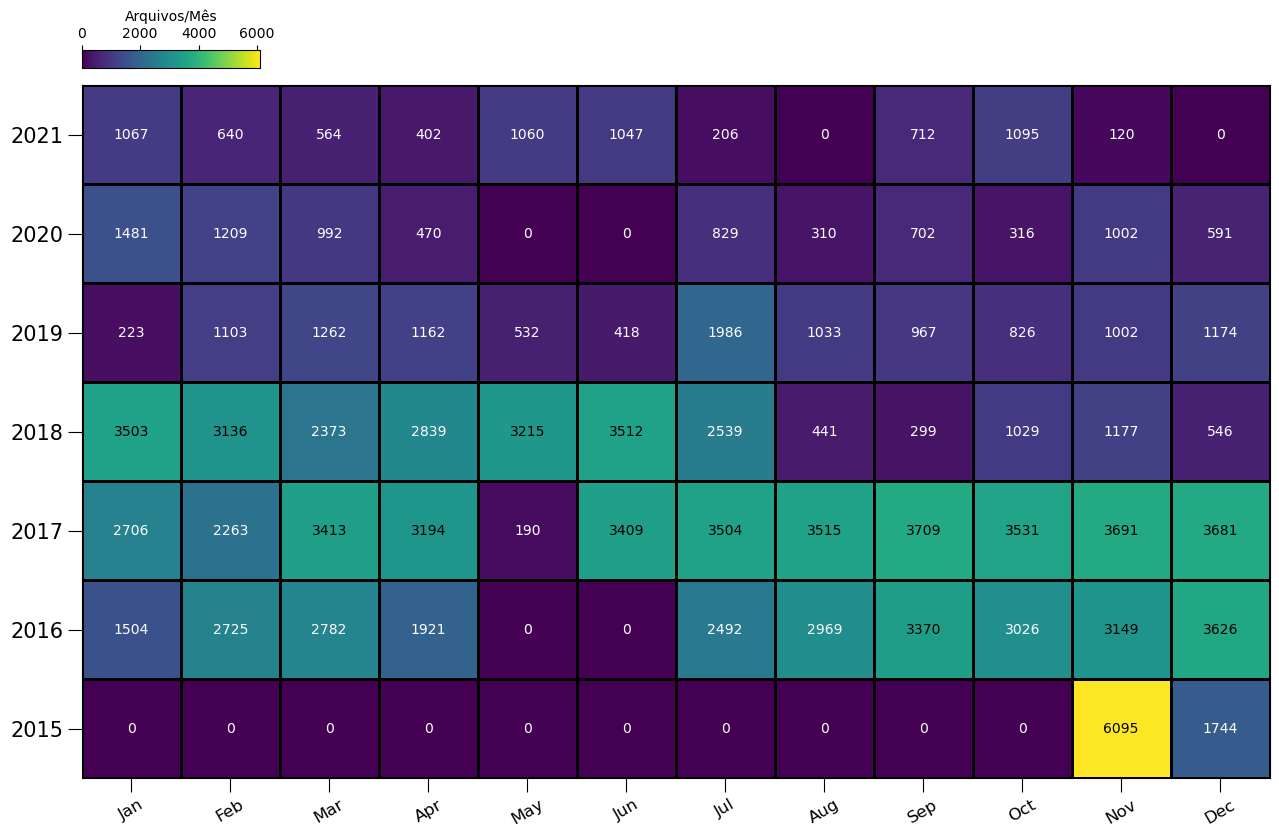

In [166]:

# ==========================
# Plotting DATA availability
# ==========================
#x axis parameters

days = DayLocator(interval=1)  # every 1 day
months = MonthLocator(interval=1)  # every 1 month
monthsFmt = DateFormatter('%b-%y')

#Matplotlib parameters
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,9))

im = ax.pcolormesh(data_x_axis,cmap='viridis', shading ='flat',ec='k')

# Get the dimensions of the array
rows, cols = data_x_axis.shape

# Loop over each cell and add the cell value as text
for i in range(rows):
    for j in range(cols):
        cell_value = int(data_x_axis[i, j])
        text_color = 'white' if cell_value < np.max(data_x_axis)/2 else 'black'
        ax.text(j + 0.5, i + 0.5, str(cell_value), color=text_color,ha='center', va='center')

# Set the tick locations and labels
# Set the x and y axis tick locations and labels
ax.set_xticks(np.arange(data_x_axis.shape[1]) + 0.5, name_months,fontsize=15)
ax.set_yticks(np.arange(data_x_axis.shape[0]) + 0.5, datetime_lista_years,fontsize=15)

ax.tick_params(which='minor', length=2)
ax.tick_params(which='major', length=10)
ax.set_aspect(1)

plt.setp(ax.xaxis.get_majorticklabels(), fontsize=12,rotation=30)

#criando a localização da barra de cores:
axins = inset_axes(ax,
                    width="15%",  # width = 15% of parent_bbox width
                    height="2.5%",  # height : 2.5%
                    loc='upper left',
                    bbox_to_anchor=(0.0, 0.05, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0,
                    )
cbar = fig.colorbar(im, cax=axins, orientation="horizontal", ticklocation='top',label='Arquivos/Mês')
os.makedirs(FOLDER_OUTPUT+'/FIGURAS/',exist_ok=True)
fig.savefig(FOLDER_OUTPUT+'/FIGURAS/'+'COMPLETENESS_CSV_'+datatime_initial.strftime("%Y")+'_'+datatime_final.strftime("%Y")+'.png',dpi=300)
